# Batch Audio Features Extraction using Librosa

<img src="soundanomaly.jpg">

<div class="alert alert-info"><b> Let's do the audio features extraction for all the files in a directory.</b></div>

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy
import librosa
import librosa.display
import IPython
from pathlib import Path

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
now = datetime.datetime.now()
print(now)

2022-03-21 12:03:27.416451


In [4]:
def CountFiles(mypath):
    print("Total of files in", mypath, "=", sum(len(files) for _, _, files in os.walk(mypath)),'\n')
    for root, _, files in os.walk(mypath):
        print(root, ":", len(files), "files")

## 1. Directory to use to generate audio features for each file

In [5]:
AUDIOFILES_DIR = "soundssamples"

In [6]:
CountFiles(AUDIOFILES_DIR)

Total of files in soundssamples = 122 

soundssamples : 0 files
soundssamples/KO : 61 files
soundssamples/OK : 61 files


## 2. Directory to save the results

In [7]:
FEATURES_DIR = 'features'

if Path(FEATURES_DIR).is_dir() == True:
    os.rmdir(FEATURES_DIR)
    print("Deleting previous directory...")
    os.mkdir(FEATURES_DIR)
    print("Directory is created")
    
if Path(FEATURES_DIR).is_dir() == False:
    os.mkdir(FEATURES_DIR)
    print("Directory is created")

CountFiles(FEATURES_DIR)

Directory is created
Total of files in features = 0 

features : 0 files


## 3. Function to extract audio features

In [8]:
def audiofeaturesextraction(audio):
    
    print(datetime.datetime.now(), "Generating audio features extraction from:", audio)
    
    # Getting some file infromations
    basename = os.path.basename(audio)
    basenamewithoutext = os.path.splitext(basename)[0]
    extension = os.path.splitext(audiofilelocation)[1][1:]
    fullfilename = audiofilelocation
    dirsname = os.path.dirname(audio)
    category = dirsname.split("/",1)[1]

    basename_df = pd.DataFrame({'filename': [basename]})
    basenamewithoutext_df = pd.DataFrame({'basename': [basenamewithoutext]})
    ext_df = pd.DataFrame({'extension': [extension]})
    dirsname_df = pd.DataFrame({'dirsname': [dirsname]})
    fullfilename_df = pd.DataFrame({'fullfilename': [fullfilename]})
    category_df = pd.DataFrame({'category': [category]})
    
    # dataframe with filename and directory information
    filename_df = pd.concat([fullfilename_df, dirsname_df, category_df, basename_df, 
                             basenamewithoutext_df, ext_df], axis=1)
    
    # Loading sound file
    y, sr = librosa.load(audio)
    
    # Harmonic & percussive
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    
    # Chroma
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    chroma_df = pd.DataFrame()

    for i in range(0,12):
        chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]

    for i in range(0,12):
        chroma_df['chroma_std_' + str(i)] = chroma_mean[i]
    
    chroma_df.loc[0] = np.concatenate((chroma_mean,chroma_std), axis=0)
    
    # MFCCS
    mfccs = librosa.feature.mfcc(y = y_harmonic, sr = sr, n_mfcc = 13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    coeffs = np.arange(0,13)

    mfccs_df = pd.DataFrame()
    
    for i in range(0,13):
        mfccs_df['mfccs_mean_'+str(i)] = mfccs_mean[i]

    for i in range(0,13):
        mfccs_df['mfccs_std_'+str(i)] = mfccs_mean[i]
        
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    
    # Cent
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis=1)[0]

    # Contrast
    contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    contrast_mean = np.mean(contrast,axis=1)
    contrast_std = np.std(contrast,axis=1)
    conts = np.arange(0,7)
    contrast_df = pd.DataFrame()

    # rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff,axis=1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent_mean','cent_std','cent_skew']

    for i in range(0,7):
        collist.append('contrast_mean_' + str(i))

    for i in range(0,7):
        collist.append('contrast_std_' + str(i))
        
    collist = collist + ['rolloff_mean','rolloff_std','rolloff_skew']
    
    for c in collist:
        spectral_df[c] = 0
    
    data=np.concatenate(([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,
                         [rolloff_mean, rolloff_std, rolloff_std]), axis=0)
    spectral_df.loc[0] = data
    
    # zrate
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate,axis=1)[0]
    zrate_df = pd.DataFrame()
    zrate_df['zrate_mean'] = 0
    zrate_df['zrate_std'] = 0
    zrate_df['zrate_skew'] = 0
    zrate_df.loc[0] = [zrate_mean,zrate_std,zrate_skew]

    # beat
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo

    # Additional informations
    sr_df = pd.DataFrame({'sampling_rate': [sr]})
    totalsamples = np.size(y)
    duration = totalsamples / sr
    totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
    duration_df = pd.DataFrame({'duration': [duration]})

    # Saving audiofeatures to a dataframe
    audiofeatures_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis=1)
    
    # Saving all results into a single dataframe
    filesaudio_df = pd.concat([filename_df, sr_df, totalsamples_df, duration_df, audiofeatures_df], axis=1)
    
    # Export to CSV for each audio file
    outputfile = FEATURES_DIR + '/' + basenamewithoutext + '_features.csv'
    filesaudio_df.to_csv(outputfile)

## 4. Let's run the function to extract audio features for each file

In [9]:
start = datetime.datetime.now()

print(start, 'Audio Features extraction...\n')

for root, dirs, files in os.walk(AUDIOFILES_DIR):
    for audiofile in files:
        audiofilelocation = root + '/' + audiofile
        audiofeaturesextraction(audiofilelocation)

end = datetime.datetime.now()
print('\n', end, 'End of job. Processing time:', end - start)

2022-03-21 12:03:30.918473 Audio Features extraction...

2022-03-21 12:03:31.003790 Generating audio features extraction from: soundssamples/KO/machine_KO_1.wav
2022-03-21 12:03:33.229372 Generating audio features extraction from: soundssamples/KO/machine_KO_10.wav
2022-03-21 12:03:34.706540 Generating audio features extraction from: soundssamples/KO/machine_KO_11.wav
2022-03-21 12:03:36.129441 Generating audio features extraction from: soundssamples/KO/machine_KO_12.wav
2022-03-21 12:03:37.598091 Generating audio features extraction from: soundssamples/KO/machine_KO_13.wav
2022-03-21 12:03:39.005669 Generating audio features extraction from: soundssamples/KO/machine_KO_14.wav
2022-03-21 12:03:40.569189 Generating audio features extraction from: soundssamples/KO/machine_KO_15.wav
2022-03-21 12:03:42.041903 Generating audio features extraction from: soundssamples/KO/machine_KO_16.wav
2022-03-21 12:03:43.696011 Generating audio features extraction from: soundssamples/KO/machine_KO_17.wav

2022-03-21 12:05:39.431039 Generating audio features extraction from: soundssamples/OK/machine_OK_27.wav
2022-03-21 12:05:41.235697 Generating audio features extraction from: soundssamples/OK/machine_OK_28.wav
2022-03-21 12:05:42.891140 Generating audio features extraction from: soundssamples/OK/machine_OK_29.wav
2022-03-21 12:05:44.381954 Generating audio features extraction from: soundssamples/OK/machine_OK_3.wav
2022-03-21 12:05:45.857825 Generating audio features extraction from: soundssamples/OK/machine_OK_30.wav
2022-03-21 12:05:47.267249 Generating audio features extraction from: soundssamples/OK/machine_OK_31.wav
2022-03-21 12:05:48.735549 Generating audio features extraction from: soundssamples/OK/machine_OK_32.wav
2022-03-21 12:05:50.172507 Generating audio features extraction from: soundssamples/OK/machine_OK_33.wav
2022-03-21 12:05:51.644535 Generating audio features extraction from: soundssamples/OK/machine_OK_34.wav
2022-03-21 12:05:53.031819 Generating audio features ext

## 5. Results

In [10]:
CountFiles(FEATURES_DIR)

Total of files in features = 122 

features : 122 files


In [11]:
os.chdir(FEATURES_DIR)

filepaths = [f for f in os.listdir() if f.endswith('.csv')] # Taking all the CSV files into a single dataframe
audiofeaturesdf = pd.concat(map(pd.read_csv, filepaths))

del audiofeaturesdf['Unnamed: 0'] # Cleaning the df
audiofeaturesdf = audiofeaturesdf.reset_index(drop=True) # Clean index

os.chdir('..')

In [12]:
audiofeaturesdf.head(10)

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,soundssamples/KO/machine_KO_10.wav,soundssamples/KO,KO,machine_KO_10.wav,machine_KO_10,wav,22050,154350,7.0,0.207955,...,1.773339,1.429958,1.657899,4518.692764,440.399918,440.399918,0.042167,0.007407,0.258770,89.102909
1,soundssamples/KO/machine_KO_11.wav,soundssamples/KO,KO,machine_KO_11.wav,machine_KO_11,wav,22050,154350,7.0,0.254265,...,1.763645,1.322384,1.638797,4614.879158,401.213119,401.213119,0.044160,0.007023,-0.039787,89.102909
2,soundssamples/KO/machine_KO_12.wav,soundssamples/KO,KO,machine_KO_12.wav,machine_KO_12,wav,22050,154350,7.0,0.211593,...,1.755350,1.650181,1.582608,4620.119855,536.040316,536.040316,0.044715,0.008462,0.491898,172.265625
3,soundssamples/KO/machine_KO_13.wav,soundssamples/KO,KO,machine_KO_13.wav,machine_KO_13,wav,22050,154350,7.0,0.257933,...,1.917433,1.334371,1.641586,4549.530878,514.010228,514.010228,0.044479,0.007700,0.093202,129.199219
4,soundssamples/KO/machine_KO_14.wav,soundssamples/KO,KO,machine_KO_14.wav,machine_KO_14,wav,22050,154350,7.0,0.184411,...,1.885364,1.531254,1.843258,4610.458435,444.688783,444.688783,0.045024,0.007941,0.282005,89.102909
5,soundssamples/KO/machine_KO_15.wav,soundssamples/KO,KO,machine_KO_15.wav,machine_KO_15,wav,22050,154350,7.0,0.254075,...,1.619934,1.454060,1.796460,4739.693304,442.264690,442.264690,0.046993,0.007622,0.165599,89.102909
6,soundssamples/KO/machine_KO_16.wav,soundssamples/KO,KO,machine_KO_16.wav,machine_KO_16,wav,22050,154350,7.0,0.212160,...,1.802330,1.539262,1.840080,4676.198876,511.497140,511.497140,0.044799,0.008729,-0.079515,89.102909
7,soundssamples/KO/machine_KO_17.wav,soundssamples/KO,KO,machine_KO_17.wav,machine_KO_17,wav,22050,154350,7.0,0.254166,...,2.054809,1.473440,1.744346,4626.822243,482.886269,482.886269,0.040799,0.007478,0.419481,89.102909
8,soundssamples/KO/machine_KO_18.wav,soundssamples/KO,KO,machine_KO_18.wav,machine_KO_18,wav,22050,154350,7.0,0.294912,...,1.812718,1.360714,1.928855,4746.466994,487.152643,487.152643,0.046081,0.008679,-0.094741,89.102909
9,soundssamples/KO/machine_KO_19.wav,soundssamples/KO,KO,machine_KO_19.wav,machine_KO_19,wav,22050,154350,7.0,0.205413,...,1.791035,1.510694,1.661646,4880.621702,379.032309,379.032309,0.046676,0.008829,0.134989,89.102909


In [13]:
audiofeaturesdf.shape

(122, 83)

In [14]:
audiofeaturesdf.columns

Index(['fullfilename', 'dirsname', 'category', 'filename', 'basename',
       'extension', 'sampling_rate', 'total_samples', 'duration',
       'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
  

In [15]:
audiofeaturesdf.describe()

,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
count,122.0,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,22050.0,153183.885246,6.947115,0.253788,0.094637,0.019204,0.005946,0.034847,0.214653,0.238726,...,1.784614,1.397470,1.624233,4789.449031,445.363320,445.363320,0.048680,0.008723,0.039972,106.213040
std,0.0,9069.934393,0.411335,0.032214,0.040835,0.013380,0.005902,0.027474,0.030051,0.045941,...,0.102431,0.082863,0.193447,137.499833,72.107572,72.107572,0.004010,0.001044,0.238079,31.174817
min,22050.0,83217.000000,3.774014,0.184411,0.004039,0.002833,0.000000,0.000000,0.133928,0.130146,...,1.550403,1.193841,0.966341,4449.494176,284.917751,284.917751,0.039957,0.006307,-0.646816,89.102909
25%,22050.0,154350.000000,7.000000,0.223551,0.063446,0.009820,0.000825,0.015362,0.196955,0.209123,...,1.728198,1.345541,1.569925,4693.471785,401.243179,401.243179,0.045955,0.007898,-0.096359,89.102909
50%,22050.0,154350.000000,7.000000,0.257006,0.096767,0.015643,0.004160,0.029296,0.211177,0.239162,...,1.781120,1.388597,1.642894,4784.043147,438.668027,438.668027,0.048857,0.008715,0.014458,89.102909
75%,22050.0,154350.000000,7.000000,0.281017,0.121934,0.024465,0.008541,0.048537,0.231735,0.256766,...,1.853805,1.442992,1.755140,4904.418743,487.845021,487.845021,0.051333,0.009365,0.188808,103.359375
max,22050.0,154350.000000,7.000000,0.313622,0.192260,0.078903,0.034572,0.125175,0.350884,0.359755,...,2.054809,1.650181,1.928927,5099.518833,627.465394,627.465394,0.060212,0.011894,1.056005,184.570312


In [16]:
audiofeaturesdf['category'].value_counts()

KO    61
OK    61
Name: category, dtype: int64

Text(0, 0.5, 'Number of files')

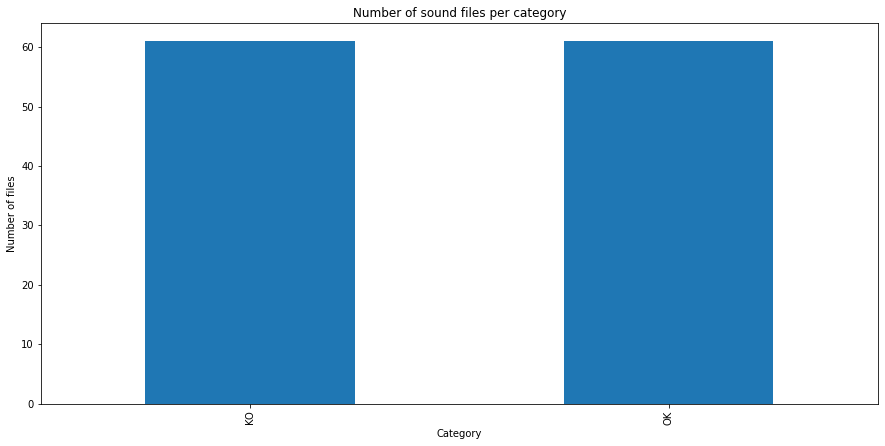

In [17]:
%matplotlib inline
ax = audiofeaturesdf['category'].value_counts().plot(kind='bar', figsize=(15,7), 
                                                     title="Number of sound files per category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of files")

## 6. EDA

In [18]:
# Let's create a sample for the EDA
pctsample = 0.1
dfsample = audiofeaturesdf.sample(frac = pctsample)

In [19]:
dfsample.head()

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
61,soundssamples/OK/machine_OK_10.wav,soundssamples/OK,OK,machine_OK_10.wav,machine_OK_10,wav,22050,154350,7.0,0.223531,...,1.800191,1.443571,1.644201,4586.714870,334.301252,334.301252,0.041300,0.007271,0.318137,89.102909
17,soundssamples/KO/machine_KO_26.wav,soundssamples/KO,KO,machine_KO_26.wav,machine_KO_26,wav,22050,154350,7.0,0.272368,...,1.820656,1.386589,1.746476,4699.942441,414.359365,414.359365,0.050641,0.007725,-0.106057,172.265625
1,soundssamples/KO/machine_KO_11.wav,soundssamples/KO,KO,machine_KO_11.wav,machine_KO_11,wav,22050,154350,7.0,0.254265,...,1.763645,1.322384,1.638797,4614.879158,401.213119,401.213119,0.044160,0.007023,-0.039787,89.102909
27,soundssamples/KO/machine_KO_35.wav,soundssamples/KO,KO,machine_KO_35.wav,machine_KO_35,wav,22050,154350,7.0,0.249816,...,1.868516,1.482351,1.838339,4781.690181,510.307184,510.307184,0.046964,0.008698,-0.042630,135.999178
42,soundssamples/KO/machine_KO_49.wav,soundssamples/KO,KO,machine_KO_49.wav,machine_KO_49,wav,22050,154350,7.0,0.297226,...,1.784448,1.399143,1.397405,4789.141239,556.000890,556.000890,0.052497,0.009561,0.267792,89.102909


## 7. Export features to CSV and Excel files

In [20]:
EXPORTFEATURES_DIR = 'featuresresults'

if Path(EXPORTFEATURES_DIR).is_dir() == False:
    os.mkdir(EXPORTFEATURES_DIR)
    print("Directory is created")

csv_output = EXPORTFEATURES_DIR + '/machineaudiofeatures.csv' # CSV filename to create
excel_output = EXPORTFEATURES_DIR + '/machineaudiofeatures.xls' # Excel filename to create

Directory is created


In [21]:
audiofeaturesdf.to_csv(csv_output)

In [22]:
audiofeaturesdf.to_excel(excel_output)

In [23]:
CountFiles(EXPORTFEATURES_DIR)

Total of files in featuresresults = 2 

featuresresults : 2 files


In [24]:
from IPython.display import FileLink

CSVLINK = FileLink(path = csv_output)
print("Click to download the file:")
CSVLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Sound/MachineSoundAnomaly/featuresresults/machineaudiofeatures.csv

In [25]:
XLSLINK = FileLink(path = excel_output)
print("Click to download the file:")
XLSLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Sound/MachineSoundAnomaly/featuresresults/machineaudiofeatures.xls

> We will use AutoML for Classification in order to predict the music genre with the extracted features